# Henry and Hilleke Problem

This notebook is patterned after a laboratory experiment of solute and heat transport.  As described in the following Groundwater paper, the problem was simulated using SEAWAT.  In this notebook, the problem is simulated using MODFLOW 6.

The following paper is available [here](https://doi.org/10.1111/j.1745-6584.2009.00596.x)

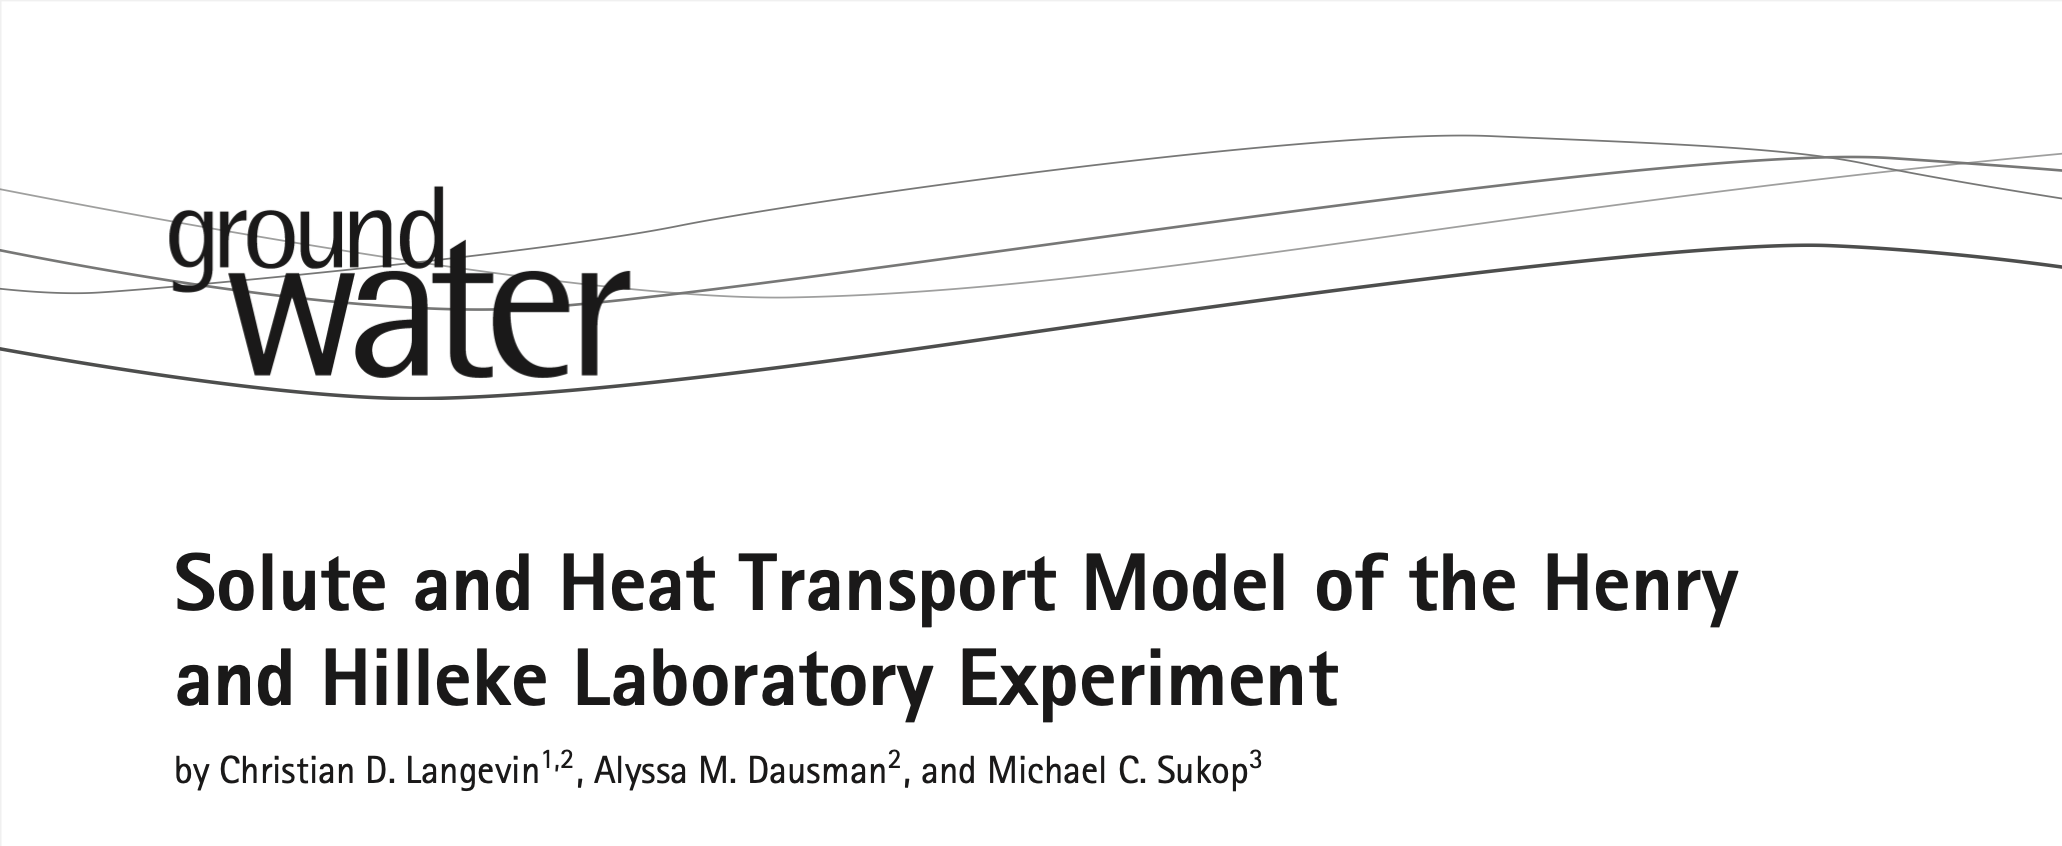

A schematic of the laboratory problem is shown in Figure 1 below.

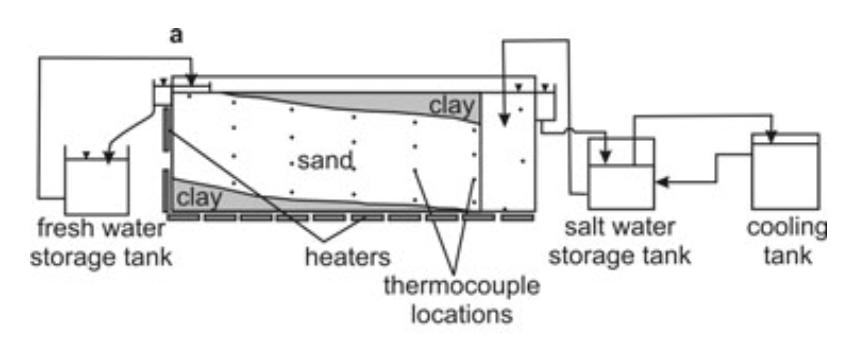

Boundary conditions for the numerical model are represented as follows.

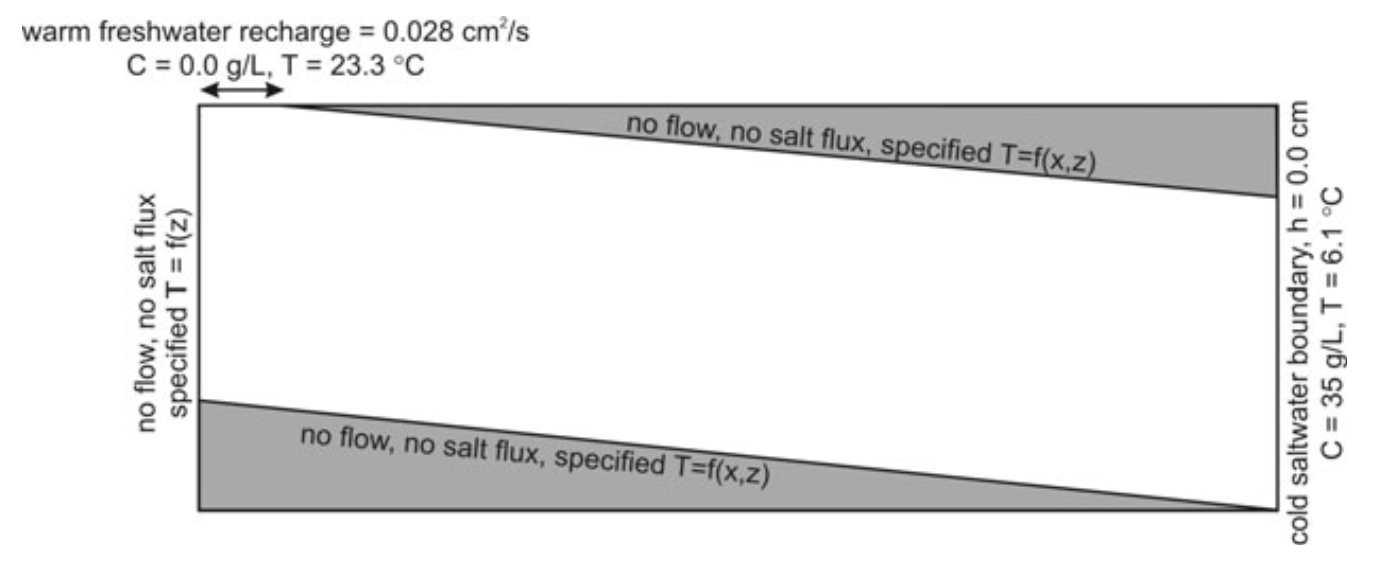

Here we represent the Henry and Hilleke laboratory experiment using MODFLOW 6.  The simulation includes four models:

1. A groundwater flow model
2. A groundwater transport model to simulate salt concentration
3. A groundwater energy model to simulate temperature
4. A particle tracking model to help visualize groundwater flow patterns

In [ ]:
from IPython.display import HTML
import pathlib as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
import pandas as pd
from shapely import Polygon, LineString
import flopy

## Define Parameters

In [ ]:
length_units = "centimeters"
time_units = "seconds"

tank_width = 15.0 # cm
nlay, nrow, ncol = 49, 5, 130
nrow = 1
delc = tank_width / nrow  # cm
delr = 2.5  # cm
delz = 2.5 # cm
top = 0.
botm = [top - (k + 1) * delz for k in range(nlay)]

# timing
perlen = 60. * 60. * 60. * 24. # 60 days converted to seconds
nstp = 1000 # int(perlen / 500.)
perioddata = [(perlen, nstp, 1.)]

temp_room = 23.33 # degrees celsius
temp_saltwater = 6.1 # degrees celsius
conc_saltwater = 35. # grams per liter
head_saltwater = 0.
denseref = 1.0
drhodc = 7.8e-4
drhodt = 3.92e-4
trhoref = 14.

# K for inside tank is 0.22
hydraulic_conductivity = np.empty((nlay, nrow, ncol))
hydraulic_conductivity.fill(0.22)

porosity = 0.3

thermal_conductivity_water = 0.58 * 1.e5 # Convert W / m K to cgs
thermal_conductivity_sand = 1.6 * 1.e5 # convert W / m K to cgs

heat_capacity_water = 4.186 * 1.e7 # convert J / g K to cgs
heat_capacity_sand = 0.710 * 1.e7 # convert J / g K to cgs

density_solid = 2.6 # g / cm^3
latheatvap = 2.454E+06

# solver
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-8, 1e-4, 0.97

In [ ]:
# Create IDOMAIN

Lx = ncol * delr
Lz = nlay * delz
clay_upper = Polygon([(30.5, 0), (Lx, 0), (Lx, top - (Lz - 91)), (30.5, 0)])
clay_lower = Polygon([(0, top - 91.), (Lx, -Lz), (0, -Lz), (0, top-91.)])
print(f"{Lx=} {Lz=}")
print(f"{clay_upper=}")
sg = flopy.discretization.StructuredGrid(
    nlay=1, 
    nrow=nlay, 
    ncol=ncol, 
    delr=delr * np.ones(ncol),
    delc=delz * np.ones(nlay),
    xoff=0.,
    yoff=-Lz,
    top=np.zeros((nlay, ncol)),
    botm=-1 * np.ones((1, nlay, ncol)),
)

idomain = np.ones((nlay, nrow, ncol), dtype=int)
for p in [clay_upper, clay_lower]:
    gi = flopy.utils.GridIntersect(sg, method="vertex")
    ra = gi.intersect(p)
    for k, j in ra["cellids"]:
        idomain[k, :, j] = 0

# constant temperature for right active edge
idx = np.where(idomain[:, :, -1] == 1)
for k, i in zip(*idx):
    idomain[k, i, -1] = 2

# constant temperature for left active edge
idx = np.where(idomain[:, :, 0] == 1)
for k, i in zip(*idx):
    idomain[k, i, 0] = 2
idomain[0, 0, 0] = 1

# line along bottom clay surface
ls = LineString([(0, top - 91.), (Lx, -Lz)])
gi = flopy.utils.GridIntersect(sg, method="vertex")
ra = gi.intersect(ls)
for k, j in ra["cellids"]:
    # set constant temperature idomain to 2
    idomain[k, :, j] = 2

# line along upper clay surface
ls = LineString([(30.5, 0), (Lx, top - (Lz - 91))])
gi = flopy.utils.GridIntersect(sg, method="vertex")
ra = gi.intersect(ls)
for k, j in ra["cellids"]:
    # set constant temperature idomain to 2
    idomain[k, :, j] = 2

In [ ]:
# Define boundaries

# recharge inflow
temp_inflow = temp_room
conc_inflow = 0.
idxrch = np.where(idomain[0, :, :] == 1)
recharge_inflow = 0.028 * 15 / (15. * 30.) / idxrch[0].shape[0]
rch_auxnames = ["CONCENTRATION", "TEMPERATURE", "IFLOWFACE"]
rch_spd = [(0, i, j, recharge_inflow, conc_inflow, temp_inflow, -1) for i, j in zip(*idxrch)]

# cold ghb boundary on right side
idxghb = np.where(idomain[:, :, -1] == 2)
ghb_auxnames = ["CONCENTRATION", "TEMPERATURE", "IFLOWFACE"]
ghb_cond = delc * delz * hydraulic_conductivity[0, 0, 0] / delr
ghb_spd = [(k, i, ncol - 1, head_saltwater, ghb_cond, conc_saltwater, temp_saltwater, 3) for k, i in zip(*idxghb)]

specified_temperature = np.empty((nlay, nrow, ncol), dtype=float)
specified_temperature.fill(np.nan)

# constant temperature boundary for bottom (interpolate from hilleke contours)
x_dist = [0, 45, 100, 180, 200, 230, 250, 275, 295, 310] + [sg.xcellcenters[0][-1]]
temp_f = [165, 100, 95, 90, 85, 80, 75, 70, 65, 60]
temp_c = [5. / 9. * (f - 32) for f in temp_f] + [temp_saltwater]
x_dist = np.array(x_dist)
temp_c = np.array(temp_c)
left_to_right_bottom_temp = np.interp(sg.xcellcenters[0], x_dist, temp_c)
idx = np.where(idomain==2)
for k, i, j in zip(*idx):
    if k > 25:
        specified_temperature[k, i, j] = left_to_right_bottom_temp[j]

# constant temp for left edge
z_dist = [0., -15, -27, -40, -90]
temp_c = [29.4, 32.2, 35.0, 37.8, 73.9]
z_dist = -np.array(z_dist)
temp_c = np.array(temp_c)
top_to_bottom_left_temp = np.interp(-sg.ycellcenters[:, 0], z_dist, temp_c)
idx = np.where(idomain[:, :, 0] == 2)
for k, i in zip(*idx):
    specified_temperature[k, i, 0] = top_to_bottom_left_temp[k]

# constant temp for top inflow
idx = np.where(idomain[:, :, :] == 2)
x_dist = [0, 30, 240, 260, 285, 310, sg.xcellcenters[0][-1]]
temp_c = [temp_room, 26.7, 23.9, 21.1, 18.3, 15.6, temp_saltwater]
x_dist = np.array(x_dist)
temp_c = np.array(temp_c)
left_to_right_top_temp = np.interp(sg.xcellcenters[0], x_dist, temp_c)
for k, i, j in zip(*idx):
    if k < 26 and j > 0:
        specified_temperature[k, i, j] = left_to_right_top_temp[j]

# set constant temperature stress period data (ctp_spd)
idx = np.where(idomain == 2)
ctp_spd = [(k, i, j, specified_temperature[k, i, j]) for k, i, j in zip(*idx) ]

In [ ]:
plt.imshow(specified_temperature[:, 0, :], cmap="jet")
plt.colorbar(shrink=0.3)

In [ ]:
plt.imshow(idomain[:, 0, :])

In [ ]:
ws = pl.Path('./temp/hh')

gwf_name = "gwf"
gwt_name = "gwt"
gwe_name = "gwe"
prt_name = "prt"
ims_print_option = "summary"
when_to_save = "ALL" # "LAST" "ALL"

sim = flopy.mf6.MFSimulation(sim_name="hh", sim_ws=ws, exe_name='mf6')
tdis = flopy.mf6.ModflowTdis(
    sim, 
    perioddata=perioddata,
    time_units=time_units,
)

gwf = flopy.mf6.ModflowGwf(sim, modelname=gwf_name, save_flows=True)
imsgwf = flopy.mf6.ModflowIms(
    sim,
    print_option=ims_print_option,
    outer_dvclose=hclose,
    outer_maximum=nouter,
    under_relaxation="NONE",
    inner_maximum=ninner,
    inner_dvclose=hclose,
    rcloserecord=rclose,
#    linear_acceleration="BICGSTAB",
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=relax,
    filename=f"{gwf.name}.ims",
)
sim.register_ims_package(imsgwf, [gwf.name])

dis = flopy.mf6.ModflowGwfdis(
    gwf, 
    length_units=length_units,
    nlay=nlay, 
    nrow=nrow, 
    ncol=ncol, 
    delr=delr, 
    delc=delc, 
    top=top, 
    botm=botm,
    idomain=idomain,
)
ic = flopy.mf6.ModflowGwfic(gwf, strt=top)
npf = flopy.mf6.ModflowGwfnpf(
    gwf, 
    save_specific_discharge=True,
    k=hydraulic_conductivity,
)
# sto = flopy.mf6.ModflowGwfsto(gwf, iconvert=0, ss=1.e-4)

# provide species, drho/dc, crhoref, modelname, and auxname
buy_pd = []
ispec = 0
if gwt_name is not None:
    buy_pd.append((ispec, drhodc, 0.0, "GWT", "CONCENTRATION"))
    ispec += 1
if gwe_name is not None:
    buy_pd.append((ispec, drhodt, trhoref, "GWE", "TEMPERATURE"))
    ispec += 1
if len(buy_pd) > 0:
    buy = flopy.mf6.ModflowGwfbuy(
        gwf, 
        denseref=denseref,
        packagedata=buy_pd,
    )

ghb = flopy.mf6.ModflowGwfghb(
    gwf, 
    auxiliary=ghb_auxnames,
    stress_period_data=ghb_spd,
    pname="GHB-1",
)
rch = flopy.mf6.ModflowGwfrch(
    gwf, 
    auxiliary=rch_auxnames,
    stress_period_data=rch_spd,
    pname="RCH-1",
)

budget_file = gwf_name + '.bud'
head_file = gwf_name + '.hds'
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    budget_filerecord=budget_file,
    head_filerecord=head_file,
    saverecord=[('HEAD', when_to_save), ('BUDGET', when_to_save)],
    printrecord=[('BUDGET', 'ALL')],
)

In [ ]:
if gwt_name is not None:
    gwt = flopy.mf6.ModflowGwt(
        sim, 
        modelname=gwt_name,
        save_flows=True,
    )
    imsgwt = flopy.mf6.ModflowIms(
        sim,
        print_option=ims_print_option,
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwt.name}.ims",
    )
    sim.register_ims_package(imsgwt, [gwt.name])
    dis = flopy.mf6.ModflowGwtdis(
        gwt,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
    )
    mst = flopy.mf6.ModflowGwtmst(gwt, porosity=porosity)
    ic = flopy.mf6.ModflowGwtic(gwt, strt=conc_saltwater)
    adv = flopy.mf6.ModflowGwtadv(gwt, scheme="UPSTREAM")
    # dsp = flopy.mf6.ModflowGwtdsp(gwt, xt3d_off=True, diffc=diffusion_coefficient)
    sourcerecarray = [
        ("GHB-1", "AUX", "CONCENTRATION"),
        ("RCH-1", "AUX", "CONCENTRATION"),
    ]
    ssm = flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray)
    oc = flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f"{gwt.name}.bud",
        concentration_filerecord=f"{gwt.name}.ucn",
        concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("CONCENTRATION", when_to_save), ("BUDGET", when_to_save)],
        printrecord=[('BUDGET', 'ALL')],
    )
    gwfgwt = flopy.mf6.ModflowGwfgwt(
        sim, exgtype="GWF6-GWT6", exgmnamea=gwf.name, exgmnameb=gwt.name
    )

In [ ]:
if gwe_name is not None:
    gwe = flopy.mf6.ModflowGwe(
        sim, 
        modelname=gwe_name,
        save_flows=True,
    )
    imsgwe = flopy.mf6.ModflowIms(
        sim,
        print_option=ims_print_option,
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwe.name}.ims",
    )
    sim.register_ims_package(imsgwe, [gwe.name])
    dis = flopy.mf6.ModflowGwedis(
        gwe,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
    )
    est_pd = [(heat_capacity_water, denseref, latheatvap)]
    est = flopy.mf6.ModflowGweest(
        gwe, 
        porosity=porosity,
        heat_capacity_solid=heat_capacity_sand,
        density_solid=density_solid,
        heat_capacity_water=heat_capacity_water,
        density_water=denseref,
        latent_heat_vaporization=latheatvap,
    )
    ic = flopy.mf6.ModflowGweic(gwe, strt=temp_saltwater)
    adv = flopy.mf6.ModflowGweadv(gwe, scheme="UPSTREAM")
    cnd = flopy.mf6.ModflowGwecnd(
        gwe, 
        xt3d_off=False, 
        ktw=thermal_conductivity_water,
        kts=thermal_conductivity_sand,
    )
    sourcerecarray = [
        ("GHB-1", "AUX", "TEMPERATURE"),
        ("RCH-1", "AUX", "TEMPERATURE"),
    ]
    ssm = flopy.mf6.ModflowGwessm(gwe, sources=sourcerecarray)
    ctp = flopy.mf6.ModflowGwectp(
        gwe, 
        stress_period_data=ctp_spd,
        pname="CTP-1"
    )
    oc = flopy.mf6.ModflowGweoc(
        gwe,
        budget_filerecord=f"{gwe.name}.bud",
        temperature_filerecord=f"{gwe.name}.ucn",
        temperatureprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("TEMPERATURE", when_to_save), ("BUDGET", when_to_save)],
        printrecord=[('BUDGET', 'ALL')],
    )
    gwfgwe = flopy.mf6.ModflowGwfgwe(
        sim, exgtype="GWF6-GWE6", exgmnamea=gwf.name, exgmnameb=gwe.name
    )

In [ ]:
if prt_name is not None:

    prt = flopy.mf6.ModflowPrt(
        sim, modelname=prt_name, model_nam_file=f"{prt_name}.nam"
    )
    dis = flopy.mf6.ModflowPrtdis(
        prt, 
        length_units=length_units,
        nlay=nlay, 
        nrow=nrow, 
        ncol=ncol, 
        delr=delr, 
        delc=delc, 
        top=top, 
        botm=botm,
        idomain=idomain,
    )
    mip = flopy.mf6.ModflowPrtmip(prt, pname="mip", porosity=porosity)

    prp_release_frequency = 50

    # prp for warm inflow boundary
    xc = prt.modelgrid.xcellcenters
    yc = prt.modelgrid.ycellcenters
    # ip, l, r, c, x, y, zoff
    prp_pd = []
    k = 1
    zc = top - k * delz - delz / 2.
    for iparticle, (i, j) in enumerate(zip(*idxrch)):
        prp_pd.append((iparticle, k, i, j, xc[i, j], yc[i, j], zc))
    prp = flopy.mf6.ModflowPrtprp(
        prt,
        pname="prp",
        filename=f"{prt_name}.prp",
        # local_z=True,
        stoptime=perlen,
        nreleasepts=len(prp_pd),
        packagedata=prp_pd,
        perioddata={
            0: [("FREQUENCY", prp_release_frequency)],
        },
        exit_solve_tolerance=1e-5,
    )

    # prp for cold seawater boundary
    prp_ghb_pd = []
    j = ncol - 1
    for iparticle, (k, i) in enumerate(zip(*idxghb)):
        zc = top - k * delz - delz / 2.
        prp_ghb_pd.append((iparticle, k, i, j, xc[i, j], yc[i, j], zc))
    prp = flopy.mf6.ModflowPrtprp(
        prt,
        pname="prp-ghb",
        filename=f"{prt_name}-ghb.prp",
        stoptime=perlen,
        nreleasepts=len(prp_ghb_pd),
        packagedata=prp_ghb_pd,
        perioddata={
            0: [("FREQUENCY", prp_release_frequency)],
        },
        exit_solve_tolerance=1e-5,
    )

    budgetfile_prt = f"{prt_name}.cbb"
    budget_record = [budgetfile_prt]
    trackfile_prt = f"{prt_name}.trk"
    track_record = [trackfile_prt]
    trackcsvfile_prt = f"{prt_name}.trk.csv"
    trackcsv_record = [trackcsvfile_prt]
    tracktimes = list(np.linspace(0, perlen, 100))
    oc = flopy.mf6.ModflowPrtoc(
        prt,
        pname="oc",
        budget_filerecord=budget_record,
        track_exit=True,
        track_timestep=True,
        # track_filerecord=track_record,
        trackcsv_filerecord=trackcsv_record,
        # track_timesrecord=tracktimes,
        saverecord=[("BUDGET", "LAST")],
    )
    ems = flopy.mf6.ModflowEms(
        sim,
        pname="ems",
        filename=f"{prt_name}.ems",
    )
    sim.register_solution_package(ems, [prt.name])

    gwfgwe = flopy.mf6.ModflowGwfprt(
        sim, exgtype="GWF6-PRT6", exgmnamea=gwf.name, exgmnameb=prt.name
    )

In [ ]:
sim.write_simulation()

In [ ]:
sim.run_simulation()

In [ ]:
# load output
head_all = None
conc_all = None
temp_all = None
track = None
qx, qy, qz = None, None, None
if gwf_name is not None:
    head_all = gwf.output.head().get_alldata()
    bud = gwf.output.budget()
    times = bud.times
    spdis = bud.get_data(text='DATA-SPDIS')[0]
    qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
if gwt_name is not None:
    conc_all = gwt.output.concentration().get_alldata()
if gwe_name is not None:
    temp_all = gwe.output.temperature().get_alldata()
if prt_name is not None:
    f = pl.Path(ws) / f"{prt.name}.trk.csv"
    track = pd.read_csv(f)

In [ ]:
# plot of flow results
itime = -1
head = head_all[itime]
t = times[itime]
pmv = flopy.plot.PlotCrossSection(gwf, line={"row": 0})
ax = plt.gca()
pmv.plot_inactive()
cb = pmv.plot_array(head, masked_values=[1e30])
levels = None
pmv.contour_array(head, levels=levels, linewidths=3.)
plt.colorbar(cb, shrink=0.5)
markercolor = {1: "blue", 2: "red"}
if prt_name is not None:
    track_times = track[(track["t"] > t - 500) & (track["t"] < t + 500)]
    mf6_plines = track_times.groupby(["iprp", "irpt", "trelease"])
    for ipl, ((iprp, irpt, trelease), pl) in enumerate(mf6_plines):
        pl.plot(
            kind="line",
            linestyle="-",
            marker="o",
            markersize=0,
            x="x",
            y="z",
            ax=ax,
            legend=False,
            color=markercolor[iprp],
        )
ax.set_aspect(1.)
head = np.ma.masked_where(idomain==0, head)
ax.set_title(f"head min ({head.min():0.2f}) head max ({head.max():0.2f})")

In [ ]:
# plot of concentration results
if gwt_name is not None:
    conc = conc_all[-1]
    conc = np.ma.masked_where(idomain==0, conc)
    bud = gwt.output.budget()

    pmv = flopy.plot.PlotCrossSection(gwt, line={"row": 0})
    ax = plt.gca()
    cb = pmv.plot_array(conc, vmin=0., vmax=35., cmap="jet")
    pmv.plot_inactive()
    levels = None
    plt.colorbar(cb, shrink=0.5)
    ax.set_aspect(1.)
    ax.set_title(f"conc min ({conc.min():0.2f}) conc max ({conc.max():0.2f})")

In [ ]:
# plot of temperature results
if gwe_name is not None:
    temp = temp_all[-1]
    temp = np.ma.masked_where(idomain==0, temp)

    pmv = flopy.plot.PlotCrossSection(gwe, line={"row": 0})
    ax = plt.gca()
    pmv.plot_inactive()
    cb = pmv.plot_array(temp, vmin=None, vmax=None, cmap="jet")
    #pmv.plot_grid(colors='white')
    levels =  5./9. * (np.arange(60, 105, 5) - 32.)
    pmv.contour_array(temp, levels=levels, linewidths=1.)
    plt.colorbar(cb, shrink=0.5)
    ax.set_aspect(1.)
    ax.set_title(f"temp min ({temp.min():0.2f}) temp max ({temp.max():0.2f})")

In [ ]:
times_to_show = times[::20]
ntimes = len(times_to_show)
print(f"There are a total of {len(times)} time steps")
print(f"{ntimes} frames will be added to the animation")

In [ ]:
def get_title(time_in_seconds):
    time_in_days = time_in_seconds / 60. / 60. / 24
    return f"Time = {time_in_days:0.2f} days"

nplotrows = 0
if gwf_name is not None:
    nplotrows += 1
if gwt_name is not None:
    nplotrows += 1
if gwe_name is not None:
    nplotrows += 1
nplotcols = 1
fig, axes = plt.subplots(
    nrows=nplotrows, 
    ncols=nplotcols, 
    figsize=(8, 7), 
    layout="constrained"
)
if nplotrows == 1:
    axes = [axes]
for iplot, ax in enumerate(axes):
    # ax.set_aspect(1)
    ax.set_ylabel(r'z')
    if iplot == 0:
        title = ax.set_title(get_title(times[0]))
    if iplot == nplotrows - 1:
        ax.set_xlabel(r'x')

# # plot persistent items
plot_array_dict = {
    "cmap": "jet",
    "masked_values": [1.e30],
}
colorbar_text_size = 10
iplot = 0
plot_map_views = []
if gwf_name is not None:
    ax = axes[iplot]
    iplot += 1
    pmv = flopy.plot.PlotCrossSection(gwf, line={"row": 0}, ax=ax)
    plot_map_views.append(pmv)
    pmv.plot_inactive()
    pa = pmv.plot_array(
        head_all[0],
        alpha=0.1,
        **plot_array_dict
    )
    cb = plt.colorbar(pa, shrink=0.5)
    cb.ax.set_ylabel('head (cm)', rotation=270, fontsize=colorbar_text_size, labelpad=15)
    cb.ax.tick_params(labelsize=colorbar_text_size)

    if prt_name is not None:
        particle_lines = []
        t = times[itime]
        markersize = 2.0
        track_times = track[(track["t"] > t - 500) & (track["t"] < t + 500)]
        mf6_plines = track_times.groupby(["iprp", "irpt", "trelease"])
        for ipl, ((iprp, irpt, trelease), pl) in enumerate(mf6_plines):
            pxy = pl.to_records()
            particles = ax.plot(
                pxy["x"], 
                pxy["z"], 
                marker="o", 
                markersize=markersize,
                color=markercolor[iprp],
            )
            particle_lines.append(particles)

if gwt_name is not None:
    ax = axes[iplot]
    iplot += 1
    pmv = flopy.plot.PlotCrossSection(gwt, line={"row": 0}, ax=ax)
    plot_map_views.append(pmv)
    pmv.plot_inactive()
    pa = pmv.plot_array(
        conc_all[0], 
        vmin=0., 
        vmax=conc_saltwater, 
        **plot_array_dict
    )
    cb = plt.colorbar(pa, shrink=0.5)
    cb.ax.set_ylabel('salinity (g/L)', rotation=270, fontsize=colorbar_text_size, labelpad=15)
    cb.ax.tick_params(labelsize=colorbar_text_size)

if gwe_name is not None:
    ax = axes[iplot]
    iplot += 1
    pmv = flopy.plot.PlotCrossSection(gwe, line={"row": 0}, ax=ax)
    plot_map_views.append(pmv)
    pmv.plot_inactive()
    pa = pmv.plot_array(
        temp_all[0],
        vmin=temp_saltwater, 
        vmax=74., 
        **plot_array_dict
    )
    cb = plt.colorbar(pa, shrink=0.5)
    cb.ax.set_ylabel('temperature (Celsius)', rotation=270, fontsize=colorbar_text_size, labelpad=15)
    cb.ax.tick_params(labelsize=colorbar_text_size)

def animate(i):
    global title
    print(".", end="", flush=True)

    itime = times.index(times_to_show[i])
    title = axes[0].set_title(get_title(times[itime]))

    iplot = 0

    if gwf_name is not None:
        ax = axes[iplot]
        pmv = plot_map_views[iplot]
        iplot += 1
        cb = pmv.plot_array(
            head_all[itime], 
            alpha=0.1,
            **plot_array_dict
        )

        if prt_name is not None:
            for particle in particle_lines:
                for p in particle:
                    p.remove()
                    del p
            particle_lines[:] = []
            t = times[itime]
            track_times = track[(track["t"] > t - 500) & (track["t"] < t + 500)]
            mf6_plines = track_times.groupby(["iprp", "irpt", "trelease"])
            for ipl, ((iprp, irpt, trelease), pl) in enumerate(mf6_plines):
                pxy = pl.to_records()
                particles = ax.plot(
                    pxy["x"], 
                    pxy["z"], 
                    marker="o", 
                    markersize=markersize, 
                    color=markercolor[iprp],
                )
                particle_lines.append(particles)

    if gwt_name is not None:
        ax = axes[iplot]
        pmv = plot_map_views[iplot]
        iplot += 1
        pa = pmv.plot_array(
            conc_all[itime], 
            vmin=0., 
            vmax=conc_saltwater, 
            **plot_array_dict
        )

    if gwe_name is not None:
        ax = axes[iplot]
        pmv = plot_map_views[iplot]
        iplot += 1
        pa = pmv.plot_array(
            temp_all[itime],
            vmin=temp_saltwater, 
            vmax=74., 
            **plot_array_dict
        )

    return

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=ntimes)
plt.close()

# HTML(ani.to_jshtml())

# can use this command to write animation to file
ani.save(ws / "hh.gif", writer="pillow", dpi=300)
# ani.save("hh.mp4")

In [ ]:
# plot of results in lower left corner
if gwt_name is not None:
    fig, axes = plt.subplots(
        nrows=1, 
        ncols=1, 
        figsize=(8, 7), 
        layout="constrained"
    )
    ax = axes

    itime = -1
    bud = gwf.output.budget()
    spdis = bud.get_data(text='DATA-SPDIS')[itime]
    qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

    conc = conc_all[itime]
    conc = np.ma.masked_where(idomain==0, conc)

    pmv = flopy.plot.PlotCrossSection(gwt, line={"row": 0}, ax=ax)
    pmv.plot_inactive()
    pa = pmv.plot_array(
        conc, 
        vmin=0., 
        vmax=conc_saltwater, 
        **plot_array_dict
    )
    pmv.plot_vector(qx, qy, qz, normalize=False, color="k")
    plt.colorbar(pa, shrink=0.5)
    # if prt_name is not None:
    #     ax.plot(track["x"], track["z"])
    ax.set_aspect(1.)
    ax.set_title(f"conc min ({conc.min():0.2f}) conc max ({conc.max():0.2f})")
    ax.set_xlim(0, 100)

In [ ]:
def get_title(time_in_seconds):
    time_in_days = time_in_seconds / 60. / 60. / 24
    return f"Time = {time_in_days:0.2f} days"

if gwt_name is not None:

    times_to_show = times[::50]
    ntimes = len(times_to_show)
    print(f"{ntimes} frames will be added to the animation")
    bud = gwf.output.budget()

    nplotrows = 1
    nplotcols = 1
    fig, axes = plt.subplots(
        nrows=nplotrows, 
        ncols=nplotcols, 
        figsize=(8, 7), 
        layout="constrained"
    )
    ax = axes
    ax.set_ylabel(r'z')
    title = ax.set_title(get_title(times[0]))
    ax.set_xlabel(r'x')
    ax.set_xlim(0, 100)

    # # plot persistent items
    plot_array_dict = {
        "cmap": "jet",
        "masked_values": [1.e30],
    }
    colorbar_text_size = 10
    pmv = flopy.plot.PlotCrossSection(gwt, line={"row": 0}, ax=ax)
    pmv.plot_inactive()
    pa = pmv.plot_array(
        conc_all[0], 
        vmin=0., 
        vmax=conc_saltwater, 
        **plot_array_dict
    )
    cb = plt.colorbar(pa, shrink=0.5)
    cb.ax.set_ylabel('salinity (g/L)', rotation=270, fontsize=colorbar_text_size, labelpad=15)
    cb.ax.tick_params(labelsize=colorbar_text_size)

    def animate(i):
        global title
        print(".", end="", flush=True)

        itime = times.index(times_to_show[i])
        title = ax.set_title(get_title(times[itime]))

        pa = pmv.plot_array(
            conc_all[itime], 
            vmin=0., 
            vmax=conc_saltwater, 
            **plot_array_dict
        )
        spdis = bud.get_data(text='DATA-SPDIS')[itime]
        qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
        pmv.plot_vector(qx, qy, qz, normalize=False, color="k")

        return

    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=ntimes)
    plt.close()

    # HTML(ani.to_jshtml())

    # can use this command to write animation to file
    ani.save(ws/ "hh2.gif", writer="pillow", dpi=300)
    # ani.save(ws / "hh_zoom.mp4")